In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import matplotlib.pyplot as plt
import lsst.meas.base
import lsst.pex.config

import lsst.afw.table
import lsst.meas.algorithms
import lsst.pex.exceptions
import lsst.meas.extensions.gaap

In [2]:
from astropy.io import fits
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')

In [117]:
from hsc_gaap.gaap import GaapTask
gaap = GaapTask(9813, 21, 'i', 
                repo='/projects/MERIAN/repo/', 
                collections='S20A/deepCoadd_calexp')
gaap._checkHSCfile()
gaap.load_merian_reference(band='N708', 
                           repo='/projects/MERIAN/repo/', 
                           collections='DECam/runs/merian/dr1_wide',
                           range=(0, 3000)
                          )
gaap.setDefaultMeasureConfig()
gaap.run()
outcat = gaap.writeObjectTable()

Loaded HSC deepCoadd_calexp image
Loaded Merian reference catalog and image
# Starting the GAaP measureTask at  Wed Nov  2 23:43:11 2022
# Finished the GAaP measureTask in 116.49 seconds.


[]

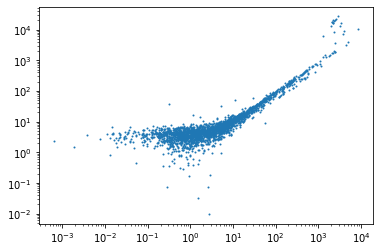

In [4]:
plt.scatter(gaap.measCat['ext_gaap_GaapFlux_1_15x_1_0_instFlux'], 
            gaap.refCat['ext_gaap_GaapFlux_1_15x_1_0_instFlux'], s=1)

plt.loglog()

# question
How to write our catalog as a final data product? including converting `instFlux` to nanomaggies?

In [18]:
a = gaap.measureConfig.plugins["ext_gaap_GaapFlux"]

In [22]:
list(a.getAllGaapResultNames())

['ext_gaap_GaapFlux_1_15x_0_3',
 'ext_gaap_GaapFlux_1_15x_0_4',
 'ext_gaap_GaapFlux_1_15x_0_5',
 'ext_gaap_GaapFlux_1_15x_0_6',
 'ext_gaap_GaapFlux_1_15x_0_75',
 'ext_gaap_GaapFlux_1_15x_1_0',
 'ext_gaap_GaapFlux_1_15x_1_5',
 'ext_gaap_GaapFlux_1_15x_2_0',
 'ext_gaap_GaapFlux_1_15x_PsfFlux',
 'ext_gaap_GaapFlux_1_15x_Optimal']

In [39]:
cat = gaap.measCat.asAstropy()
old_gaap_cols = [item for item in gaap.measCat.schema.getOrderedNames() if 'gaap' in item]
cat = cat[['objectId', 'coord_ra', 'coord_dec'] + old_gaap_cols]

In [40]:
import astropy.units as u

In [41]:
for col in old_gaap_cols:
    if 'instFlux' in col:
        cat[col] = cat[col].value * gaap.exposure.photoCalib.instFluxToMagnitude(1) * u.nanomaggy

In [30]:
gaap.exposure.photoCalib.instFluxToNanojansky(1)

57.543993733715425

In [99]:
new_gaap_cols = []
for col in old_gaap_cols:
    name = col.replace('ext_gaap_GaapFlux', 'N708_gaap')
    name = name.replace('_instFlux', 'Flux').replace('PsfFlux', 'Psf')
    if 'Flux' in name:
        aper = name.split("x_")[-1].replace('FluxErr', '').replace('Flux', '')
        name = name.replace('_1_15x', '')
        name = name.replace('_' + aper, aper.replace('_', 'p'))
        
    if 'flag' in name:
        aper = name.split("x_")[-1].replace('_flag_bigPsf', '').replace('_flag', '')
        name = name.replace('_1_15x', '')
        if not 'gauss' in name:
            name = name.replace('_' + aper, aper.replace('_', 'p') + 'Flux')
    new_gaap_cols.append(name)

0_3 N708_gaap_1_15x_0_3_flag_bigPsf
0_3 N708_gaap_1_15x_0_3_flag
0_4 N708_gaap_1_15x_0_4_flag_bigPsf
0_4 N708_gaap_1_15x_0_4_flag
0_5 N708_gaap_1_15x_0_5_flag_bigPsf
0_5 N708_gaap_1_15x_0_5_flag
0_6 N708_gaap_1_15x_0_6_flag_bigPsf
0_6 N708_gaap_1_15x_0_6_flag
0_75 N708_gaap_1_15x_0_75_flag_bigPsf
0_75 N708_gaap_1_15x_0_75_flag
1_0 N708_gaap_1_15x_1_0_flag_bigPsf
1_0 N708_gaap_1_15x_1_0_flag
1_5 N708_gaap_1_15x_1_5_flag_bigPsf
1_5 N708_gaap_1_15x_1_5_flag
2_0 N708_gaap_1_15x_2_0_flag_bigPsf
2_0 N708_gaap_1_15x_2_0_flag
Psf N708_gaap_1_15x_Psf_flag
Optimal N708_gaap_1_15x_Optimal_flag_bigPsf
Optimal N708_gaap_1_15x_Optimal_flag
flag_gaussianization N708_gaap_1_15x_flag_gaussianization
N708_gaap_edge N708_gaap_flag_edge
N708_gaap N708_gaap_flag


In [27]:
cat.rename_columns()

objectId,coord_ra,coord_dec,ext_gaap_GaapFlux_1_15x_0_3_instFlux,ext_gaap_GaapFlux_1_15x_0_3_instFluxErr,ext_gaap_GaapFlux_1_15x_0_4_instFlux,ext_gaap_GaapFlux_1_15x_0_4_instFluxErr,ext_gaap_GaapFlux_1_15x_0_5_instFlux,ext_gaap_GaapFlux_1_15x_0_5_instFluxErr,ext_gaap_GaapFlux_1_15x_0_6_instFlux,ext_gaap_GaapFlux_1_15x_0_6_instFluxErr,ext_gaap_GaapFlux_1_15x_0_75_instFlux,ext_gaap_GaapFlux_1_15x_0_75_instFluxErr,ext_gaap_GaapFlux_1_15x_1_0_instFlux,ext_gaap_GaapFlux_1_15x_1_0_instFluxErr,ext_gaap_GaapFlux_1_15x_1_5_instFlux,ext_gaap_GaapFlux_1_15x_1_5_instFluxErr,ext_gaap_GaapFlux_1_15x_2_0_instFlux,ext_gaap_GaapFlux_1_15x_2_0_instFluxErr,ext_gaap_GaapFlux_1_15x_PsfFlux_instFlux,ext_gaap_GaapFlux_1_15x_PsfFlux_instFluxErr,ext_gaap_GaapFlux_OptimalShape_xx,ext_gaap_GaapFlux_OptimalShape_yy,ext_gaap_GaapFlux_OptimalShape_xy,ext_gaap_GaapFlux_1_15x_Optimal_instFlux,ext_gaap_GaapFlux_1_15x_Optimal_instFluxErr,ext_gaap_GaapFlux_1_15x_0_3_flag_bigPsf,ext_gaap_GaapFlux_1_15x_0_3_flag,ext_gaap_GaapFlux_1_15x_0_4_flag_bigPsf,ext_gaap_GaapFlux_1_15x_0_4_flag,ext_gaap_GaapFlux_1_15x_0_5_flag_bigPsf,ext_gaap_GaapFlux_1_15x_0_5_flag,ext_gaap_GaapFlux_1_15x_0_6_flag_bigPsf,ext_gaap_GaapFlux_1_15x_0_6_flag,ext_gaap_GaapFlux_1_15x_0_75_flag_bigPsf,ext_gaap_GaapFlux_1_15x_0_75_flag,ext_gaap_GaapFlux_1_15x_1_0_flag_bigPsf,ext_gaap_GaapFlux_1_15x_1_0_flag,ext_gaap_GaapFlux_1_15x_1_5_flag_bigPsf,ext_gaap_GaapFlux_1_15x_1_5_flag,ext_gaap_GaapFlux_1_15x_2_0_flag_bigPsf,ext_gaap_GaapFlux_1_15x_2_0_flag,ext_gaap_GaapFlux_1_15x_PsfFlux_flag,ext_gaap_GaapFlux_1_15x_Optimal_flag_bigPsf,ext_gaap_GaapFlux_1_15x_Optimal_flag,ext_gaap_GaapFlux_1_15x_flag_gaussianization,ext_gaap_GaapFlux_flag_edge,ext_gaap_GaapFlux_flag
,rad,rad,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,pix2,pix2,pix2,ct,ct,,,,,,,,,,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
3495901618560303105,2.620422211895717,0.03079809882863815,134.17587202277528,0.5024770484247121,185.38560740459593,0.39971353089337375,236.62720228661757,0.4331301102065413,286.191109014699,0.4848885585550471,354.07659442108377,0.5749930459825846,446.1177322587686,0.7376351826078803,564.4076351809877,1.0776764916415316,631.5720797702219,1.424036171943357,188.82011088938452,0.40085763997490087,27.056269026794173,37.12386571183085,6.932159406113907,431.3533579631917,0.6950193473453383,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3495901618560303108,2.6204196189771727,0.030742902705392667,0.05927456364104037,0.38293430819695584,0.1871395304630715,0.33732330195675614,0.22192547131617985,0.36798417088965013,0.2542069955450651,0.41322698314777473,0.3050593983184747,0.4910962094003236,0.37194530583251756,0.6309733962568408,0.37804165808089824,0.9227709451236263,0.35060602292335236,1.2197528941154143,0.18661395971957973,0.33714365556614667,nan,nan,nan,nan,nan,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False
3495901618560303109,2.6202954409347075,0.03072649737470207,-0.1594914661886054,0.40466716253334156,-0.17666659226230857,0.35519068031020046,-0.24099684582240466,0.38732644173169173,-0.2795548025382564,0.43486938159757954,-0.3280020855136624,0.5167496522093988,-0.4214208794979272,0.6638728464368935,-0.4864401606715424,0.9708261793453488,-0.38875486612056653,1.2832480936833173,-0.17600545704871706,0.3550590118579757,17.539315591365213,8.161409225674971,-0.1467259591071865,-0.3749365380343386,0.43371591810891086,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3495901618560303110,2.62017728891

In [105]:
good_objects = ~(outcat["i_gaap_flag"] | outcat['i_gaapOptimalFlux_flag_bigPsf'])
np.sum(good_objects), len(good_objects)

(1430, 3000)

/tmp/ipykernel_266711/3204027037.py:13: RuntimeWarning: invalid value encountered in true_divide
  snr = gaap.measCat[baseName+"_instFlux"][good_objects] / gaap.measCat[baseName+"_instFluxErr"][good_objects]


Text(0.5, 0, 'Sigmas')

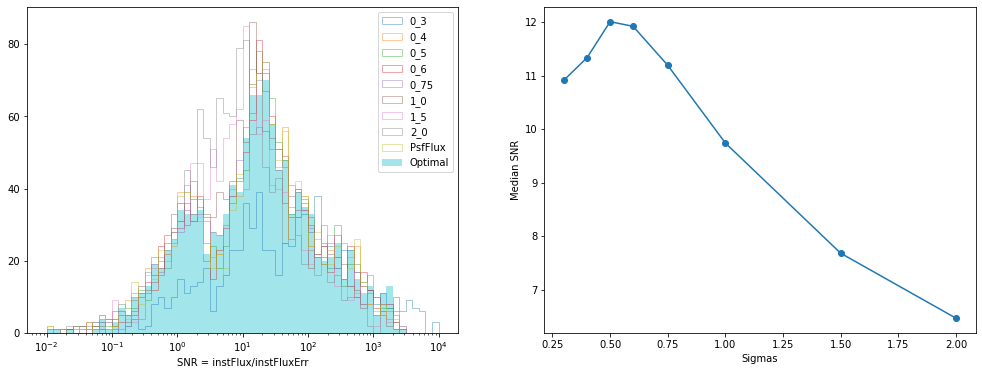

In [106]:
fig, ax = plt.subplots(1, 2, figsize=(17,6))
bins = np.logspace(-2,4,61)

baseNames = list(gaap.measureConfig.plugins["ext_gaap_GaapFlux"].getAllGaapResultNames("ext_gaap_GaapFlux"))
statistic_list = []
statistic_upper_list, statistic_lower_list = [], []

for baseName in gaap.measureConfig.plugins["ext_gaap_GaapFlux"].getAllGaapResultNames("ext_gaap_GaapFlux"):
    label = baseName.split("x_")[-1]
    #if label[-1]=='5': continue
#     if "PsfFlux" in label: continue
    histtype='stepfilled' if "Optimal" in baseName else 'step'
    snr = gaap.measCat[baseName+"_instFlux"][good_objects] / gaap.measCat[baseName+"_instFluxErr"][good_objects]
    ax[0].hist(snr, bins=bins, histtype=histtype,label=label, alpha=0.4)
    statistic = np.nanpercentile(snr, 50)
    # statistic = np.nanmean(snr)
    if "Optimal" in label:
        optStatistic = np.nanpercentile(snr, 50)
    if not ("PsfFlux" in label or "Optimal" in label):
        statistic_list.append(statistic)
        statistic_upper_list.append(np.percentile(snr, 84))
        statistic_lower_list.append(np.percentile(snr, 16))

ax[0].set_xscale('log')
ax[0].set_xlabel("SNR = instFlux/instFluxErr")
#ax[0].set_yscale('log')
ax[0].legend(loc='best')

sigmas = gaap.measureConfig.plugins["ext_gaap_GaapFlux"].sigmas.list()
ax[1].plot(sigmas, statistic_list, 'o-')
#ax[1].fill_between(sigmas, statistic_upper_list, statistic_lower_list, alpha=0.4)
# ax[1].plot(3.6, optStatistic, "*", markersize=12)
ax[1].set_ylabel("Median SNR")
ax[1].set_xlabel("Sigmas")
# ax[1].axvline(3.5, color='k', ls='-.')

In [7]:
# Load Merian catalog as reference
filt = 'N708'
tract = 9813
patch = 56
patch_old = f'{patch % 9},{patch // 9}'

import lsst.daf.butler as dafButler
butler = dafButler.Butler('/projects/MERIAN/repo/')
dataId = dict(tract=tract, patch=patch, band=filt)
refCat = butler.get(
    'objectTable',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)
refCat = refCat[:1000]

In [13]:
[item for item in refCat.columns.to_numpy() if 'gaap' in item]

['N540_gaapPsfFlux',
 'N540_gaapPsfFluxErr',
 'N540_gaap0p5Flux',
 'N540_gaap0p5FluxErr',
 'N540_gaap0p7Flux',
 'N540_gaap0p7FluxErr',
 'N540_gaap1p0Flux',
 'N540_gaap1p0FluxErr',
 'N540_gaap1p5Flux',
 'N540_gaap1p5FluxErr',
 'N540_gaap2p5Flux',
 'N540_gaap2p5FluxErr',
 'N540_gaap3p0Flux',
 'N540_gaap3p0FluxErr',
 'N540_gaapOptimalFlux',
 'N540_gaapOptimalFluxErr',
 'N540_gaapFlux_flag',
 'N540_gaapFlux_flag_edge',
 'N540_gaapFlux_flag_gaussianization',
 'N540_gaapOptimalFlux_flag_bigPsf',
 'N540_gaap0p5Flux_flag_bigPsf',
 'N540_gaap0p7Flux_flag_bigPsf',
 'N540_gaap1p0Flux_flag_bigPsf',
 'N540_gaap1p5Flux_flag_bigPsf',
 'N540_gaap2p5Flux_flag_bigPsf',
 'N540_gaap3p0Flux_flag_bigPsf',
 'N708_gaapPsfFlux',
 'N708_gaapPsfFluxErr',
 'N708_gaap0p5Flux',
 'N708_gaap0p5FluxErr',
 'N708_gaap0p7Flux',
 'N708_gaap0p7FluxErr',
 'N708_gaap1p0Flux',
 'N708_gaap1p0FluxErr',
 'N708_gaap1p5Flux',
 'N708_gaap1p5FluxErr',
 'N708_gaap2p5Flux',
 'N708_gaap2p5FluxErr',
 'N708_gaap3p0Flux',
 'N708_gaap3p0Fl

## Try gaap with reference catalog

In [115]:
# Load Merian catalog as reference
filt = 'N708'
tract = 9813
patch = 56
patch_old = f'{patch % 9},{patch // 9}'

import lsst.daf.butler as dafButler
butler = dafButler.Butler('/projects/MERIAN/repo/')
dataId = dict(tract=tract, patch=patch, band=filt)
refCat = butler.get(
    'deepCoadd_forced_src',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)
refCat = refCat[:1000]
refExposure = butler.get(
    'deepCoadd_calexp',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)

In [116]:
exposure = lsst.afw.image.ExposureF(f"/projects/MERIAN/repo/S20A/9813/{patch_old}/calexp-HSC-I-{tract}-{patch_old}.fits")
# exposure = lsst.afw.image.ExposureF(
#     "/projects/MERIAN/repo/HSC/runs/RC2/w_2022_04/DM-33402/20220128T212035Z/deepCoadd_calexp/9813/79/i/deepCoadd_calexp_9813_79_i_hsc_rings_v1_HSC_runs_RC2_w_2022_04_DM-33402_20220128T212035Z.fits")
# exposure = lsst.afw.image.ExposureF(
#     "/projects/MERIAN/repo/DECam/runs/merian/dr1_wide/20220921T193246Z/deepCoadd_calexp/9813/79/N708/deepCoadd_calexp_9813_79_N708_hsc_rings_v1_DECam_runs_merian_dr1_wide_20220921T193246Z.fits")

In [118]:
measureConfig = lsst.meas.base.ForcedMeasurementConfig()
measureConfig.plugins.names.add("ext_gaap_GaapFlux")
measureConfig.plugins.names.add("base_SdssShape")
measureConfig.plugins.names.add("base_SdssCentroid")
measureConfig.plugins.names.add("ext_gaap_GaapFlux")
measureConfig.plugins["ext_gaap_GaapFlux"].doMeasure = True  # Set it to False for timing comparison
measureConfig.plugins["ext_gaap_GaapFlux"].doPsfPhotometry = True
measureConfig.plugins["ext_gaap_GaapFlux"].doOptimalPhotometry = False
measureConfig.plugins["ext_gaap_GaapFlux"].sigmas = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0]
measureTask2 = lsst.meas.base.ForcedMeasurementTask(refSchema=refCat.schema, config=measureConfig)

In [119]:
catalog = measureTask2.generateMeasCat(refExposure, refCat, refExposure.wcs, refCat.getIdFactory())
# measureTask2.attachTransformedFootprints(catalog, refCat, refExposure, refExposure.wcs)

In [120]:
print("# Starting the measureTask at ", time.ctime())
t1 = time.time()
measureTask2.run(catalog, exposure, refCat=refCat, refWcs=refExposure.wcs)
t2 = time.time()
print("# Finished measureTask in %.2f seconds." % (t2-t1))
cat2 = catalog.copy(deep=True).asAstropy()

# Starting the measureTask at  Wed Nov  2 16:50:29 2022
# Finished measureTask in 44.05 seconds.


[]

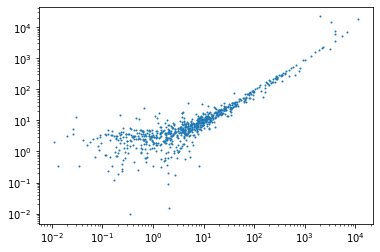

In [121]:
plt.scatter(catalog['ext_gaap_GaapFlux_1_15x_1_0_instFlux'], refCat['ext_gaap_GaapFlux_1_15x_1_0_instFlux'], s=1)

plt.loglog()

[]

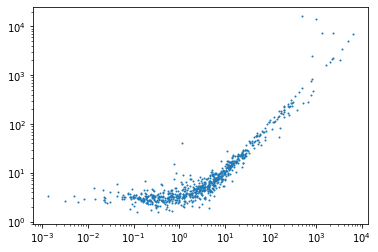

In [122]:
plt.scatter(catalog['base_PsfFlux_instFlux'], refCat['base_PsfFlux_instFlux'], s=1)

plt.loglog()

### WriteObjectTable

In [46]:
cat2 = gaap.measCat.copy(deep=True).asAstropy()

In [49]:
import astropy.units as u

In [50]:
cat2['coord_ra'] = cat2['coord_ra'].to(u.deg)
cat2['coord_dec'] = cat2['coord_dec'].to(u.deg)

In [53]:
gaap.measCat.schema.getNames()

{'base_CircularApertureFlux_12_0_flag',
 'base_CircularApertureFlux_12_0_flag_apertureTruncated',
 'base_CircularApertureFlux_12_0_instFlux',
 'base_CircularApertureFlux_12_0_instFluxErr',
 'base_CircularApertureFlux_17_0_flag',
 'base_CircularApertureFlux_17_0_flag_apertureTruncated',
 'base_CircularApertureFlux_17_0_instFlux',
 'base_CircularApertureFlux_17_0_instFluxErr',
 'base_CircularApertureFlux_25_0_flag',
 'base_CircularApertureFlux_25_0_flag_apertureTruncated',
 'base_CircularApertureFlux_25_0_instFlux',
 'base_CircularApertureFlux_25_0_instFluxErr',
 'base_CircularApertureFlux_35_0_flag',
 'base_CircularApertureFlux_35_0_flag_apertureTruncated',
 'base_CircularApertureFlux_35_0_instFlux',
 'base_CircularApertureFlux_35_0_instFluxErr',
 'base_CircularApertureFlux_3_0_flag',
 'base_CircularApertureFlux_3_0_flag_apertureTruncated',
 'base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated',
 'base_CircularApertureFlux_3_0_instFlux',
 'base_CircularApertureFlux_3_0_instFluxErr',


In [105]:
a = exposure.getPhotoCalib()

In [106]:
a.instFluxToNanojansky(1)

57.543993733715425

In [107]:
cat2.write('./my_own_gaap_s20a_79.fits', overwrite=True)

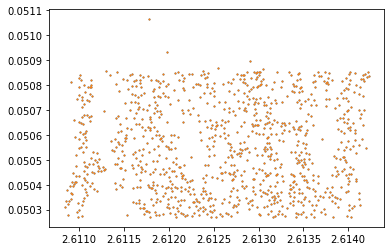

In [108]:
plt.scatter(catalog['coord_ra'], catalog['coord_dec'], s=1)
plt.scatter(refCat['coord_ra'], refCat['coord_dec'], s=1)

(array([1.73963134, 0.46082949, 1.50921659, 2.23502304, 2.00460829,
        0.94470046, 0.34562212, 0.17281106, 0.13824885, 0.0921659 ,
        0.02304147, 0.05760369, 0.06912442, 0.01152074, 0.04608295,
        0.03456221, 0.03456221, 0.04608295, 0.01152074, 0.02304147]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 [<matplotlib.patches.Polygon at 0x2b09a3a8be80>])

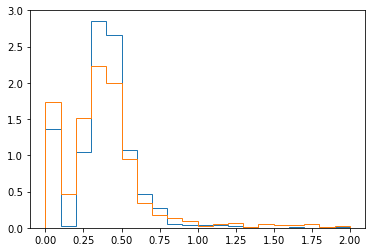

In [109]:
plt.hist(0.168 * ((cat2['base_SdssShape_xx'] * cat2['base_SdssShape_yy'] - cat2['base_SdssShape_xy']**2))**0.25,
         range=(0, 2), bins=20, histtype='step', density=True)

plt.hist(0.168 * ((refCat['base_SdssShape_xx'] * refCat['base_SdssShape_yy'] - refCat['base_SdssShape_xy']**2))**0.25,
         range=(0, 2), bins=20, histtype='step', density=True)